# PTQ basic


In [1]:
# Basic imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_on_gpu = torch.cuda.is_available()

if torch.cuda.is_available():
  device = torch.device("cuda")
  print('Training on GPU')
else:
  device = torch.device("cpu")
  print('Training on CPU')

Training on GPU


In [3]:
def norm1(x,y):
  return np.sum(np.abs(x-y))

def norm2(x,y):
  return np.sqrt(np.sum(np.square(x-y)))

## ResNet20 model


*   pretrained model on cifar10


### Build model

In [4]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
print(model)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 29.5MB/s

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

## Example

*   first layer quantization

extract a first conv layer from pre-trained model


In [5]:
for name, param in model.named_parameters():
  layername = '.'.join(name.split('.')[:1])
  # print(name)
  if layername =='conv1':
    conv = param.cpu().detach().numpy()
    activation_map = F.relu(param).cpu().detach().numpy()

<function matplotlib.pyplot.grid(visible=None, which='major', axis='both', **kwargs)>

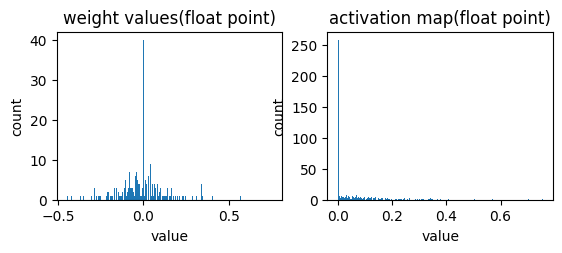

In [6]:
plt.subplot(221)
plt.hist(conv.flatten(), bins=len(np.unique(conv)))
plt.xlabel('value')
plt.ylabel('count')
plt.title('weight values(float point)')
plt.grid
plt.subplot(222)
plt.hist(activation_map.flatten(), bins=len(np.unique(activation_map)))
plt.xlabel('value')
plt.ylabel('count')
plt.title('activation map(float point)')
plt.grid

In [7]:
def calcScaleZeroPoint(min_val, max_val, num_bits):
  qmin = 0.
  qmax = 2. ** num_bits - 1.
  scale = (max_val - min_val) / (qmax - qmin)

  zero_point = qmax - max_val / scale

  if zero_point < qmin:
    zero_point = qmax
  elif zero_point > qmax:
    zero_point = qmax
  np.round(zero_point)

  return scale, zero_point

def sym_quant(x, bits=8, per_ch=True):
  q_x = x.copy()
  dq_x = x.copy()
  qmin = -2**(bits-1)
  qmax = 2**(bits-1)-1
  if per_ch:
    for i in range(len(x)):
      scale = (np.max(x[i,...]) - np.min(x[i,...])) / (qmax - qmin)
      q_x[i,...] = np.clip(np.round(x[i,...]/scale),qmin,qmax)
      # dequantize
      dq_x[i,...] = q_x[i,...]*scale
  else:
    scale = (np.max(x) - np.min(x)) / (qmax - qmin)
    q_x = np.clip(np.round(x/scale),qmin, qmax)
    # dequantize
    dq_x = q_x * scale
  return q_x, dq_x, scale

def asym_quant(x, bits=8):
  q_x = x.copy()
  dq_x = x.copy()
  qmin = 0
  qmax = 2**(bits)-1
  scale, zero_point = calcScaleZeroPoint(np.min(x),np.max(x),bits)
  q_x = np.clip(np.round(x/scale) - zero_point,qmin,qmax)
  # dequantize
  dq_x = (q_x+ zero_point)* scale
  return q_x, dq_x, scale

In [8]:
bitW, bitA = 4, 8
q_conv, dq_conv, w_scale = sym_quant(conv,bitW,per_ch=True)
q_activation_map, dq_activation_map, a_scale = asym_quant(activation_map, bitA)

print("Unique weight value :", len(np.unique(conv)))
print("Unique activation_map value :",len(np.unique(activation_map)))
print("Unique quantized weight value : {}, Scale : {}".format(len(np.unique(dq_conv)),w_scale))
print("Unique quantized activation_map value :",len(np.unique(dq_activation_map)))
print(conv[0])
print(q_conv[0])
print(dq_conv[0])

Unique weight value : 432
Unique activation_map value : 203
Unique quantized weight value : 167, Scale : 0.02549980084101359
Unique quantized activation_map value : 87
[[[ 0.10722458  0.23039667  0.21197166]
  [-0.10904633 -0.07924361 -0.0068827 ]
  [-0.1151433  -0.11287555 -0.03325838]]

 [[ 0.08255653  0.18426326  0.16416804]
  [-0.08594965 -0.06521992 -0.01451785]
  [-0.06364308 -0.06273274 -0.02375495]]

 [[ 0.05802716  0.09216097  0.08233646]
  [-0.05352959 -0.07943284 -0.05554247]
  [-0.0576319  -0.0851902  -0.08278662]]]
[[[ 5.  7.  7.]
  [-5. -3. -0.]
  [-5. -5. -1.]]

 [[ 4.  7.  7.]
  [-4. -3. -1.]
  [-3. -3. -1.]]

 [[ 3.  4.  4.]
  [-2. -3. -2.]
  [-3. -4. -4.]]]
[[[ 0.11518     0.16125199  0.16125199]
  [-0.11518    -0.06910799 -0.        ]
  [-0.11518    -0.11518    -0.023036  ]]

 [[ 0.092144    0.16125199  0.16125199]
  [-0.092144   -0.06910799 -0.023036  ]
  [-0.06910799 -0.06910799 -0.023036  ]]

 [[ 0.06910799  0.092144    0.092144  ]
  [-0.046072   -0.06910799 -0.04

<function matplotlib.pyplot.grid(visible=None, which='major', axis='both', **kwargs)>

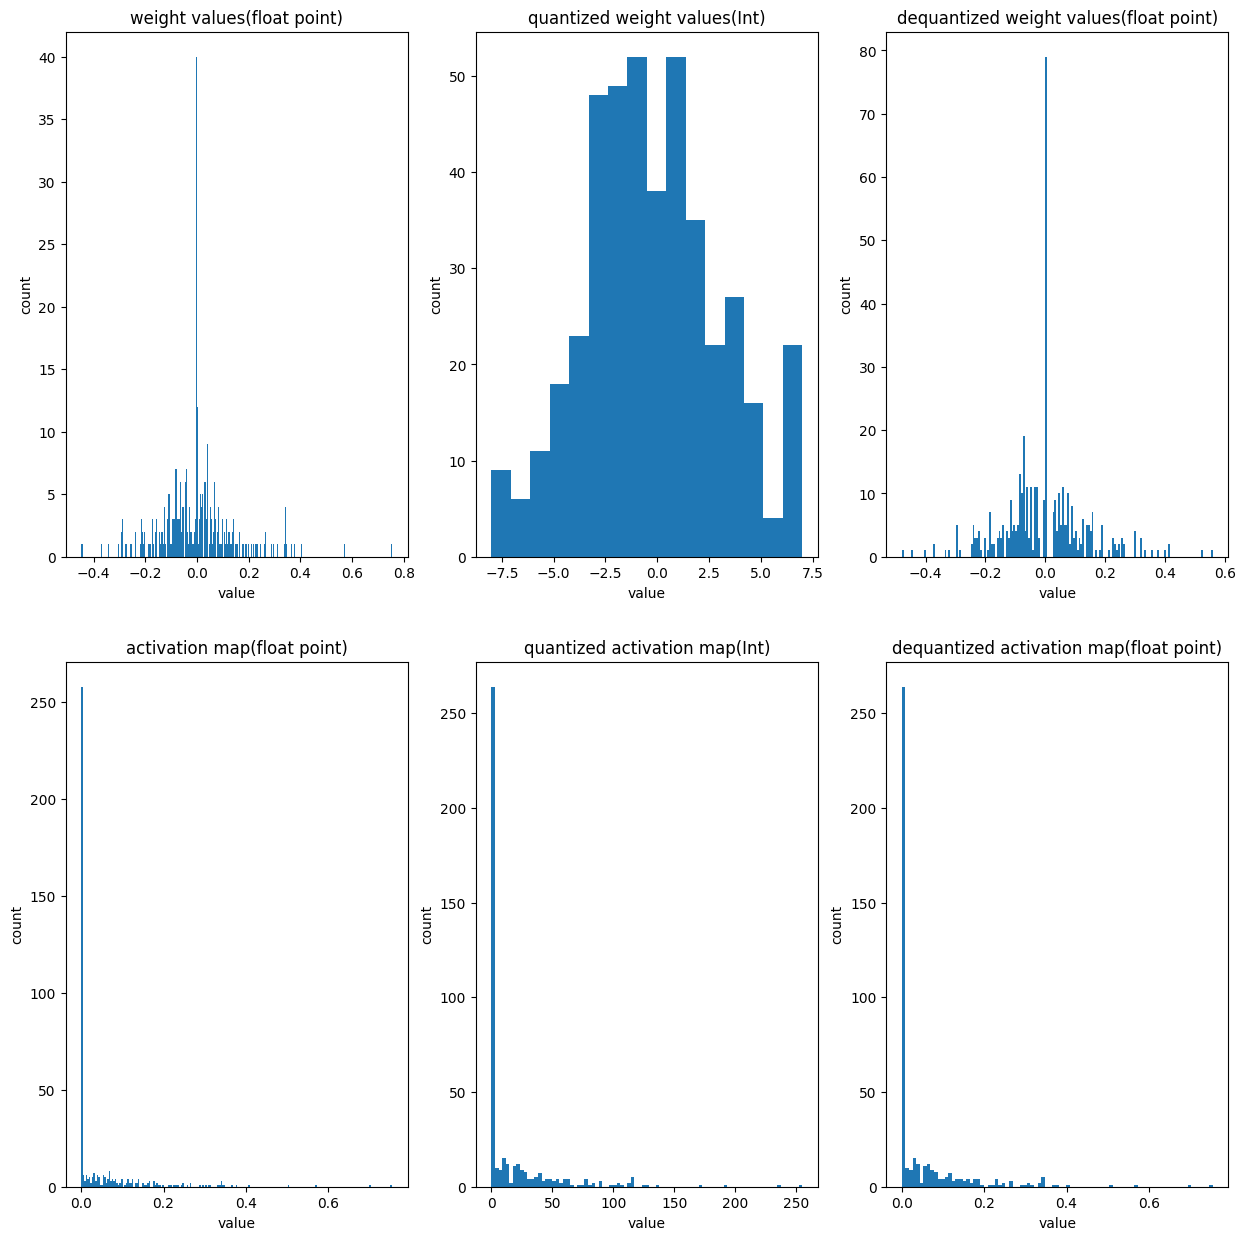

In [9]:
fig = plt.figure(figsize = (15,15))
plt.subplot(231)
plt.hist(conv.flatten(), bins=len(np.unique(conv)))
plt.xlabel('value')
plt.ylabel('count')
plt.title('weight values(float point)')
plt.grid

plt.subplot(232)
plt.hist(q_conv.flatten(), bins=len(np.unique(q_conv)))
plt.xlabel('value')
plt.ylabel('count')
plt.title('quantized weight values(Int)')
plt.grid

plt.subplot(233)
plt.hist(dq_conv.flatten(), bins=len(np.unique(dq_conv)))
plt.xlabel('value')
plt.ylabel('count')
plt.title('dequantized weight values(float point)')
plt.grid

plt.subplot(234)
plt.hist(activation_map.flatten(), bins=len(np.unique(activation_map)))
plt.xlabel('value')
plt.ylabel('count')
plt.title('activation map(float point)')
plt.grid

plt.subplot(235)
plt.hist(q_activation_map.flatten(), bins=len(np.unique(q_activation_map)))
plt.xlabel('value')
plt.ylabel('count')
plt.title('quantized activation map(Int)')
plt.grid

plt.subplot(236)
plt.hist(dq_activation_map.flatten(), bins=len(np.unique(dq_activation_map)))
plt.xlabel('value')
plt.ylabel('count')
plt.title('dequantized activation map(float point)')
plt.grid

# plt.subplots_adjust(wspace = 0.5)

In [ ]:
print('loss at norm1 :', norm1(conv,dq_conv))
print('loss at norm2 :', norm2(conv,dq_conv))

loss at norm1 : 5.266391
loss at norm2 : 0.4830898
